In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

In [ ]:
def filter_classes(dataset, selected_classes):
    filtered_data = []
    filtered_targets = []
    for i in range(len(dataset)):
        if dataset.targets[i] in selected_classes:
            filtered_data.append(dataset.data[i])
            filtered_targets.append(dataset.targets[i])
    return filtered_data, filtered_targets


In [ ]:
class CustomCIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:

class_labels = [3, 5, 7]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_data, train_labels = filter_classes(train_dataset, class_labels)
test_data, test_labels = filter_classes(test_dataset, class_labels)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(train_dataset)
print(test_dataset)


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [ ]:
print(len(train_data))
print(len(test_data))

15000
3000


In [ ]:

test_data_final = []
test_labels_final = []
for label in class_labels:
    idxs = np.where(np.array(test_labels) == label)[0][:1000]
    test_data_final.extend(np.array(test_data)[idxs])
    test_labels_final.extend(np.array(test_labels)[idxs])

In [ ]:
train_dataset_custom = CustomCIFAR10Dataset(train_data, train_labels, transform)
test_dataset_custom = CustomCIFAR10Dataset(test_data_final, test_labels_final, transform)

In [ ]:
train_indices, val_indices = train_test_split( np.arange(len(train_dataset_custom)), test_size=0.2, stratify=train_labels, random_state=42)

In [ ]:
train_subset = torch.utils.data.Subset(train_dataset_custom, train_indices)
val_subset = torch.utils.data.Subset(train_dataset_custom, val_indices)

In [ ]:
batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_custom, batch_size=batch_size, shuffle=False)


In [ ]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break


torch.Size([64, 3, 32, 32])
torch.Size([64])


In [ ]:
def imshow(images, labels, class_names):
    images = images / 2 + 0.5
    np_images = images.numpy()
    np_images = np.transpose(np_images, (0, 2, 3, 1))

    fig, axes = plt.subplots(1, len(images), figsize=(12, 2))
    for i in range(len(images)):
        ax = axes[i]
        ax.imshow(np_images[i])
        ax.set_title(class_names[int(labels[i])])
        ax.axis('off')
    plt.show()

In [ ]:
def collect_images(dataset, class_labels, num_images_per_class=5):
    images_by_class = {label: [] for label in class_labels}
    labels_by_class = {label: [] for label in class_labels}

    for idx, (image, label) in enumerate(dataset):
        if label in class_labels and len(images_by_class[label]) < num_images_per_class:
            images_by_class[label].append(image)
            labels_by_class[label].append(label)

        if all(len(images_by_class[label]) >= num_images_per_class for label in class_labels):
            break

    return images_by_class, labels_by_class

In [ ]:
train_images_by_class, train_labels_by_class = collect_images(train_dataset_custom, class_labels)
val_images_by_class, val_labels_by_class = collect_images(val_subset, class_labels)


In [ ]:
class_names = {3: 'Cat', 5: 'Dog', 7: 'Bird'}


Training dataset - Cat: 5 images


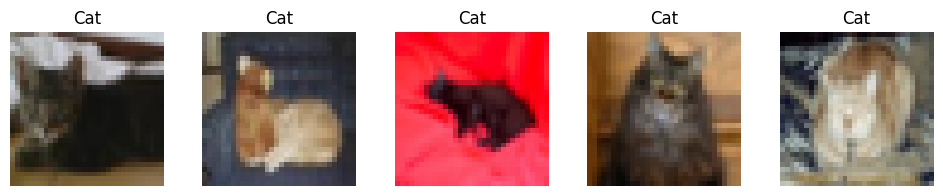

Training dataset - Dog: 5 images


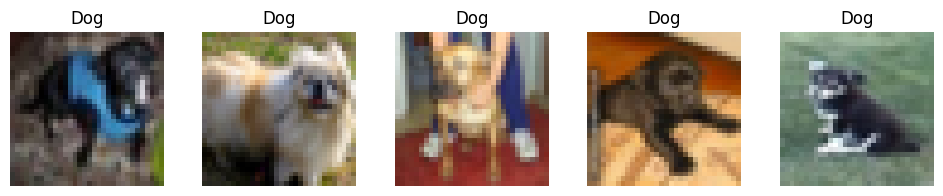

Training dataset - Bird: 5 images


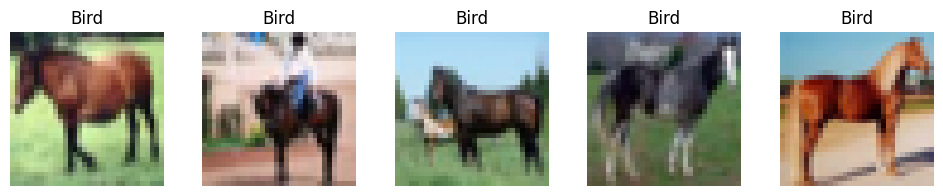

In [ ]:
for label in class_labels:
    print(f"Training dataset - {class_names[label]}: 5 images")
    imshow(torch.stack(train_images_by_class[label]), torch.tensor(train_labels_by_class[label]), class_names)

Validation dataset - Cat: 5 images


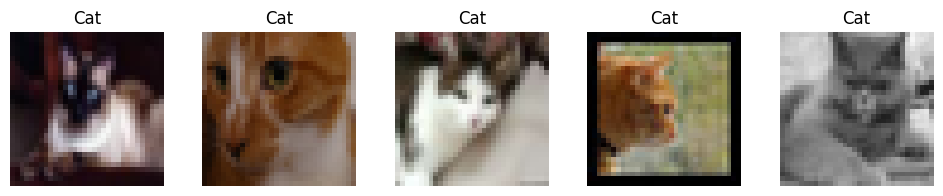

Validation dataset - Dog: 5 images


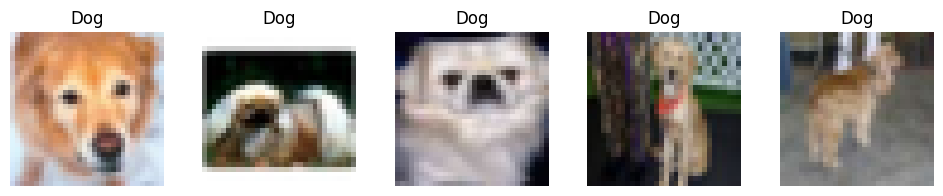

Validation dataset - Bird: 5 images


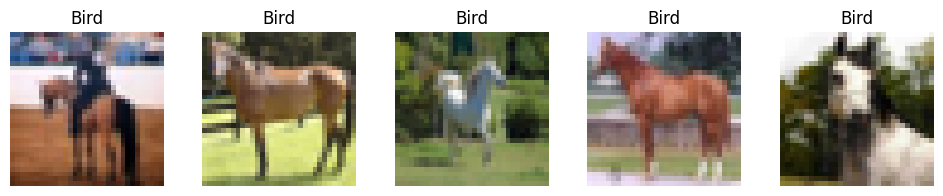

In [ ]:
for label in class_labels:
    print(f"Validation dataset - {class_names[label]}: 5 images")
    imshow(torch.stack(val_images_by_class[label]), torch.tensor(val_labels_by_class[label]), class_names)


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=1)

        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)

        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)

        self.fc1 = None
        self.fc2 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))

        x = self.pool2(F.relu(self.conv2(x)))

        flattened_size = np.prod(x.size()[1:])

        if self.fc1 is None:
            self.fc1 = nn.Linear(flattened_size, 16)

        x = x.view(-1, flattened_size)

        x = F.relu(self.fc1(x))

        x = self.fc2(x)

        return x


In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [ ]:

cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

selected_classes = [0, 1, 2]

indices = [i for i, target in enumerate(cifar10.targets) if target in selected_classes]
filtered_dataset = Subset(cifar10, indices)


Files already downloaded and verified


In [ ]:
train_size = int(0.8 * len(filtered_dataset))
val_size = len(filtered_dataset) - train_size
train_dataset, val_dataset = random_split(filtered_dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
model = CNNModel(num_classes=3)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

Epoch 1/15, Train Loss: 0.8651, Train Accuracy: 59.15%, Val Loss: 0.6818, Val Accuracy: 73.40%
Epoch 2/15, Train Loss: 0.6202, Train Accuracy: 75.27%, Val Loss: 0.5823, Val Accuracy: 77.50%
Epoch 3/15, Train Loss: 0.5529, Train Accuracy: 77.92%, Val Loss: 0.5383, Val Accuracy: 78.57%
Epoch 4/15, Train Loss: 0.5103, Train Accuracy: 79.60%, Val Loss: 0.5043, Val Accuracy: 80.07%
Epoch 5/15, Train Loss: 0.4804, Train Accuracy: 80.98%, Val Loss: 0.4752, Val Accuracy: 81.70%
Epoch 6/15, Train Loss: 0.4603, Train Accuracy: 81.58%, Val Loss: 0.4629, Val Accuracy: 82.23%
Epoch 7/15, Train Loss: 0.4384, Train Accuracy: 82.56%, Val Loss: 0.4538, Val Accuracy: 82.70%
Epoch 8/15, Train Loss: 0.4280, Train Accuracy: 82.97%, Val Loss: 0.4482, Val Accuracy: 82.43%
Epoch 9/15, Train Loss: 0.4138, Train Accuracy: 83.47%, Val Loss: 0.4311, Val Accuracy: 83.20%
Epoch 10/15, Train Loss: 0.4008, Train Accuracy: 84.27%, Val Loss: 0.4370, Val Accuracy: 82.67%
Epoch 11/15, Train Loss: 0.3920, Train Accuracy: 

In [ ]:
torch.save(model.state_dict(), 'cnn_model.pth')
plt.figure(figsize=(12, 6))


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

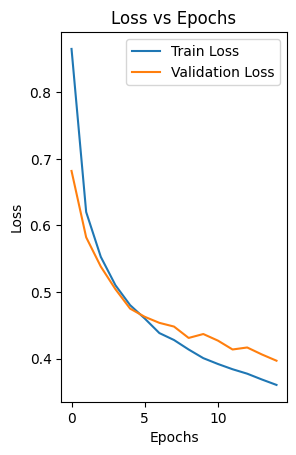

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

In [ ]:
model.eval()
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [ ]:
test_indices = [i for i, target in enumerate(test_dataset.targets) if target in selected_classes]
test_dataset = Subset(test_dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test F1-Score: {f1:.2f}")


Test Accuracy: 0.85
Test F1-Score: 0.85


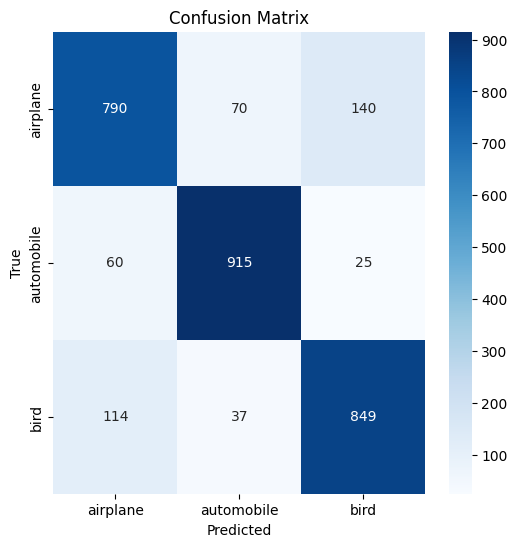

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["airplane", "automobile", "bird"],
            yticklabels=["airplane", "automobile", "bird"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
class MLPModel(nn.Module):
    def __init__(self, num_classes=3):
        super(MLPModel, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(3 * 32 * 32, 64)

        self.relu = nn.ReLU()

        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.flatten(x)

        x = self.relu(self.fc1(x))

        x = self.fc2(x)

        return x


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [ ]:
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
selected_classes = [0, 1, 2]


Files already downloaded and verified


In [ ]:
indices = [i for i, target in enumerate(cifar10.targets) if target in selected_classes]
filtered_dataset = Subset(cifar10, indices)

In [ ]:
train_size = int(0.8 * len(filtered_dataset))
val_size = len(filtered_dataset) - train_size
train_dataset, val_dataset = random_split(filtered_dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
model = MLPModel(num_classes=3)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
epochs = 15

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")


Epoch 1/15, Train Loss: 0.6998, Train Accuracy: 71.51%, Val Loss: 0.6085, Val Accuracy: 76.87%
Epoch 2/15, Train Loss: 0.5655, Train Accuracy: 77.54%, Val Loss: 0.5809, Val Accuracy: 76.67%
Epoch 3/15, Train Loss: 0.5123, Train Accuracy: 79.94%, Val Loss: 0.5664, Val Accuracy: 77.83%
Epoch 4/15, Train Loss: 0.4632, Train Accuracy: 81.99%, Val Loss: 0.5744, Val Accuracy: 76.97%
Epoch 5/15, Train Loss: 0.4294, Train Accuracy: 83.48%, Val Loss: 0.5466, Val Accuracy: 79.00%
Epoch 6/15, Train Loss: 0.3962, Train Accuracy: 84.72%, Val Loss: 0.5550, Val Accuracy: 79.07%
Epoch 7/15, Train Loss: 0.3712, Train Accuracy: 85.73%, Val Loss: 0.5511, Val Accuracy: 78.77%
Epoch 8/15, Train Loss: 0.3385, Train Accuracy: 87.26%, Val Loss: 0.5735, Val Accuracy: 80.03%
Epoch 9/15, Train Loss: 0.3249, Train Accuracy: 88.01%, Val Loss: 0.5741, Val Accuracy: 79.03%
Epoch 10/15, Train Loss: 0.2982, Train Accuracy: 89.02%, Val Loss: 0.5981, Val Accuracy: 79.77%
Epoch 11/15, Train Loss: 0.2751, Train Accuracy: 

In [ ]:
torch.save(model.state_dict(), 'mlp_model.pth')

plt.figure(figsize=(12, 6))



<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

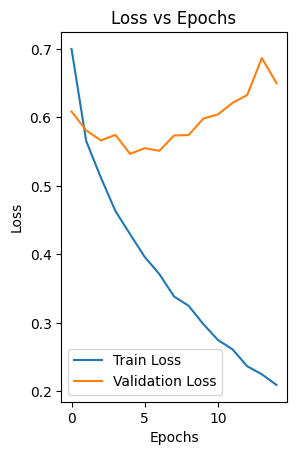

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()


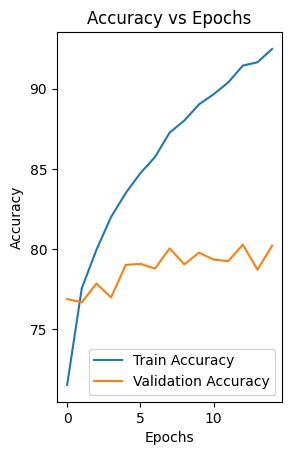

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.show()

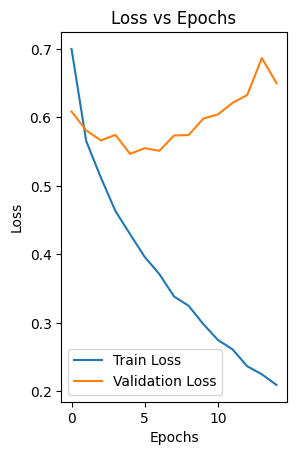

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()


In [ ]:
model.eval()
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_indices = [i for i, target in enumerate(test_dataset.targets) if target in selected_classes]
test_dataset = Subset(test_dataset, test_indices)

Files already downloaded and verified


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())


In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.80


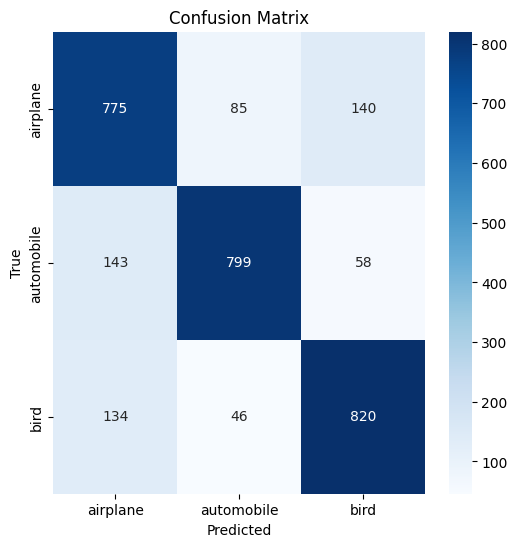

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["airplane", "automobile", "bird"],
            yticklabels=["airplane", "automobile", "bird"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
